In [11]:
import pandas as pd
import numpy as np
import re
import logging
import hashlib
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

class DataRiskManager:
    def __init__(self, log_file: str = 'data_risk_management.log'):
        """Initialize the Data Risk Manager with logging configuration."""
        # Set up logging
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

        # Define sentiment mapping
        self.sentiment_map = {
            'NEUTRAL': 0,
            'BULLISH': 1,
            'BEARISH': -1
        }

    def mask_personal_info(self, text: str) -> str:
        """Mask sensitive information in text."""
        if pd.isna(text):
            return text
        text = str(text)
        # Mask email addresses
        text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '[EMAIL_MASKED]', text)
        # Mask phone numbers (various formats)
        text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '[PHONE_MASKED]', text)
        # Mask URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                     '[URL_MASKED]', text)
        return text

    def anonymize_user_id(self, user_id: str) -> str:
        """Hash user IDs for anonymization."""
        return hashlib.sha256(str(user_id).encode()).hexdigest()[:12]

    def map_sentiment(self, sentiment: str) -> float:
        """Map categorical sentiment to numerical values."""
        if pd.isna(sentiment):
            return 0.0
        sentiment = str(sentiment).upper()  # Convert to uppercase for consistency
        return self.sentiment_map.get(sentiment, 0.0)  # Default to 0.0 if sentiment not found

    def process_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Main data processing pipeline with risk management."""
        try:
            # Create a copy to avoid modifying the original dataframe
            df = df.copy()

            # Convert categorical sentiment to numerical values
            df['sentiment_numeric'] = df['sentiment'].apply(self.map_sentiment)

            # Data preprocessing with privacy protection
            df['user_anonymized'] = df['User'].apply(self.anonymize_user_id)
            df['text_cleaned'] = df['Text'].apply(self.mask_personal_info)

            # Add risk metrics using pre-calculated sentiment
            df['follower_influence'] = np.log1p(df['Followers'].fillna(0)) / np.log1p(df['Followers'].fillna(0).max())
            df['sentiment_intensity'] = abs(df['sentiment_numeric'])

            return df

        except Exception as e:
            self.logger.error(f"Error processing data: {str(e)}")
            raise

    def visualize_sentiment_analysis(self, df: pd.DataFrame):
        """Create visualizations for sentiment analysis."""
        # Set the default style
        plt.style.use('default')

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))

        # 1. Sentiment Distribution
        sentiment_counts = df['sentiment'].value_counts()
        axes[0,0].bar(sentiment_counts.index, sentiment_counts.values)
        axes[0,0].set_title('Distribution of Sentiment Categories', pad=20, fontsize=12)
        axes[0,0].set_xlabel('Sentiment', fontsize=10)
        axes[0,0].set_ylabel('Count', fontsize=10)

        # 2. Sentiment vs Follower Influence
        sns.boxplot(data=df, x='sentiment', y='follower_influence', ax=axes[0,1])
        axes[0,1].set_title('Follower Influence by Sentiment', pad=20, fontsize=12)
        axes[0,1].set_xlabel('Sentiment', fontsize=10)
        axes[0,1].set_ylabel('Follower Influence (log-scaled)', fontsize=10)

        # 3. Average Sentiment Over Time
        df['date'] = pd.to_datetime(df['Date'])
        daily_sentiment = df.groupby(df['date'].dt.date)['sentiment_numeric'].mean().reset_index()
        axes[1,0].plot(daily_sentiment['date'], daily_sentiment['sentiment_numeric'])
        axes[1,0].set_title('Average Daily Sentiment', pad=20, fontsize=12)
        axes[1,0].set_xlabel('Date', fontsize=10)
        axes[1,0].set_ylabel('Average Sentiment\n(-1: Bearish, 0: Neutral, 1: Bullish)', fontsize=10)
        axes[1,0].tick_params(axis='x', rotation=45)

        # 4. Sentiment Distribution by Influence Level
        df['influence_category'] = pd.qcut(df['follower_influence'],
                                         q=4,
                                         labels=['Low', 'Medium', 'High', 'Very High'])
        sns.boxplot(data=df, x='influence_category', y='sentiment_numeric', ax=axes[1,1])
        axes[1,1].set_title('Sentiment Distribution by Influence Level', pad=20, fontsize=12)
        axes[1,1].set_xlabel('Influence Level', fontsize=10)
        axes[1,1].set_ylabel('Sentiment\n(-1: Bearish, 0: Neutral, 1: Bullish)', fontsize=10)

        plt.tight_layout()
        plt.show()

    def analyze_influential_tweets(self, df: pd.DataFrame, threshold: float = 0.8):
        """Analyze tweets from influential users."""
        influential_tweets = df[df['follower_influence'] > threshold].copy()
        influential_tweets = influential_tweets.sort_values('follower_influence', ascending=False)

        print(f"Number of influential tweets: {len(influential_tweets)}")

        # Sentiment distribution for influential tweets
        plt.figure(figsize=(10, 6))
        sns.countplot(data=influential_tweets, x='sentiment')
        plt.title('Sentiment Distribution for Influential Tweets')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return influential_tweets[['date', 'text_cleaned', 'sentiment', 'sentiment_numeric', 'follower_influence']]

Original Data Shape: (20850, 7)


,Unnamed: 0,Date,Text,User,Followers,Friends,sentiment
0,0,2015-12-29 09:33:17+00:00,"AAPL Apple, Inc. Bid Size\nhttps://t.co/Z2nP2D...",DennyT14,875,847,NEUTRAL
1,1,2015-12-29 18:29:22+00:00,RT @CNNMoney: What was your favorite app of th...,cyprusbiz,4841,5105,NEUTRAL
2,2,2015-12-29 04:13:13+00:00,"$AAPL Investor Opinions Updated Monday, Decemb...",bosocial,603,142,NEUTRAL
3,3,2015-12-29 17:28:49+00:00,RT @LearnBonds: Apple Inc. App Store Was Just ...,AppleNewsOutlet,99,22,NEUTRAL
4,4,2015-12-29 19:03:15+00:00,$AAPL I don't mean to spoil it but rather put ...,DayTradeTK,34,0,BULLISH



Processed Data Shape: (20850, 12)


,Unnamed: 0,Date,Text,User,Followers,Friends,sentiment,sentiment_numeric,user_anonymized,text_cleaned,follower_influence,sentiment_intensity
0,0,2015-12-29 09:33:17+00:00,"AAPL Apple, Inc. Bid Size\nhttps://t.co/Z2nP2D...",DennyT14,875,847,NEUTRAL,0,ae7529da8e89,"AAPL Apple, Inc. Bid Size\n[URL_MASKED]\n\n$AA...",0.438231,0
1,1,2015-12-29 18:29:22+00:00,RT @CNNMoney: What was your favorite app of th...,cyprusbiz,4841,5105,NEUTRAL,0,1b7d91422aaf,RT @CNNMoney: What was your favorite app of th...,0.548816,0
2,2,2015-12-29 04:13:13+00:00,"$AAPL Investor Opinions Updated Monday, Decemb...",bosocial,603,142,NEUTRAL,0,6a8212e8ac48,"$AAPL Investor Opinions Updated Monday, Decemb...",0.414184,0
3,3,2015-12-29 17:28:49+00:00,RT @LearnBonds: Apple Inc. App Store Was Just ...,AppleNewsOutlet,99,22,NEUTRAL,0,b66ecd230825,RT @LearnBonds: Apple Inc. App Store Was Just ...,0.297863,0
4,4,2015-12-29 19:03:15+00:00,$AAPL I don't mean to spoil it but rather put ...,DayTradeTK,34,0,BULLISH,1,664fc403beb4,$AAPL I don't mean to spoil it but rather put ...,0.229960,1


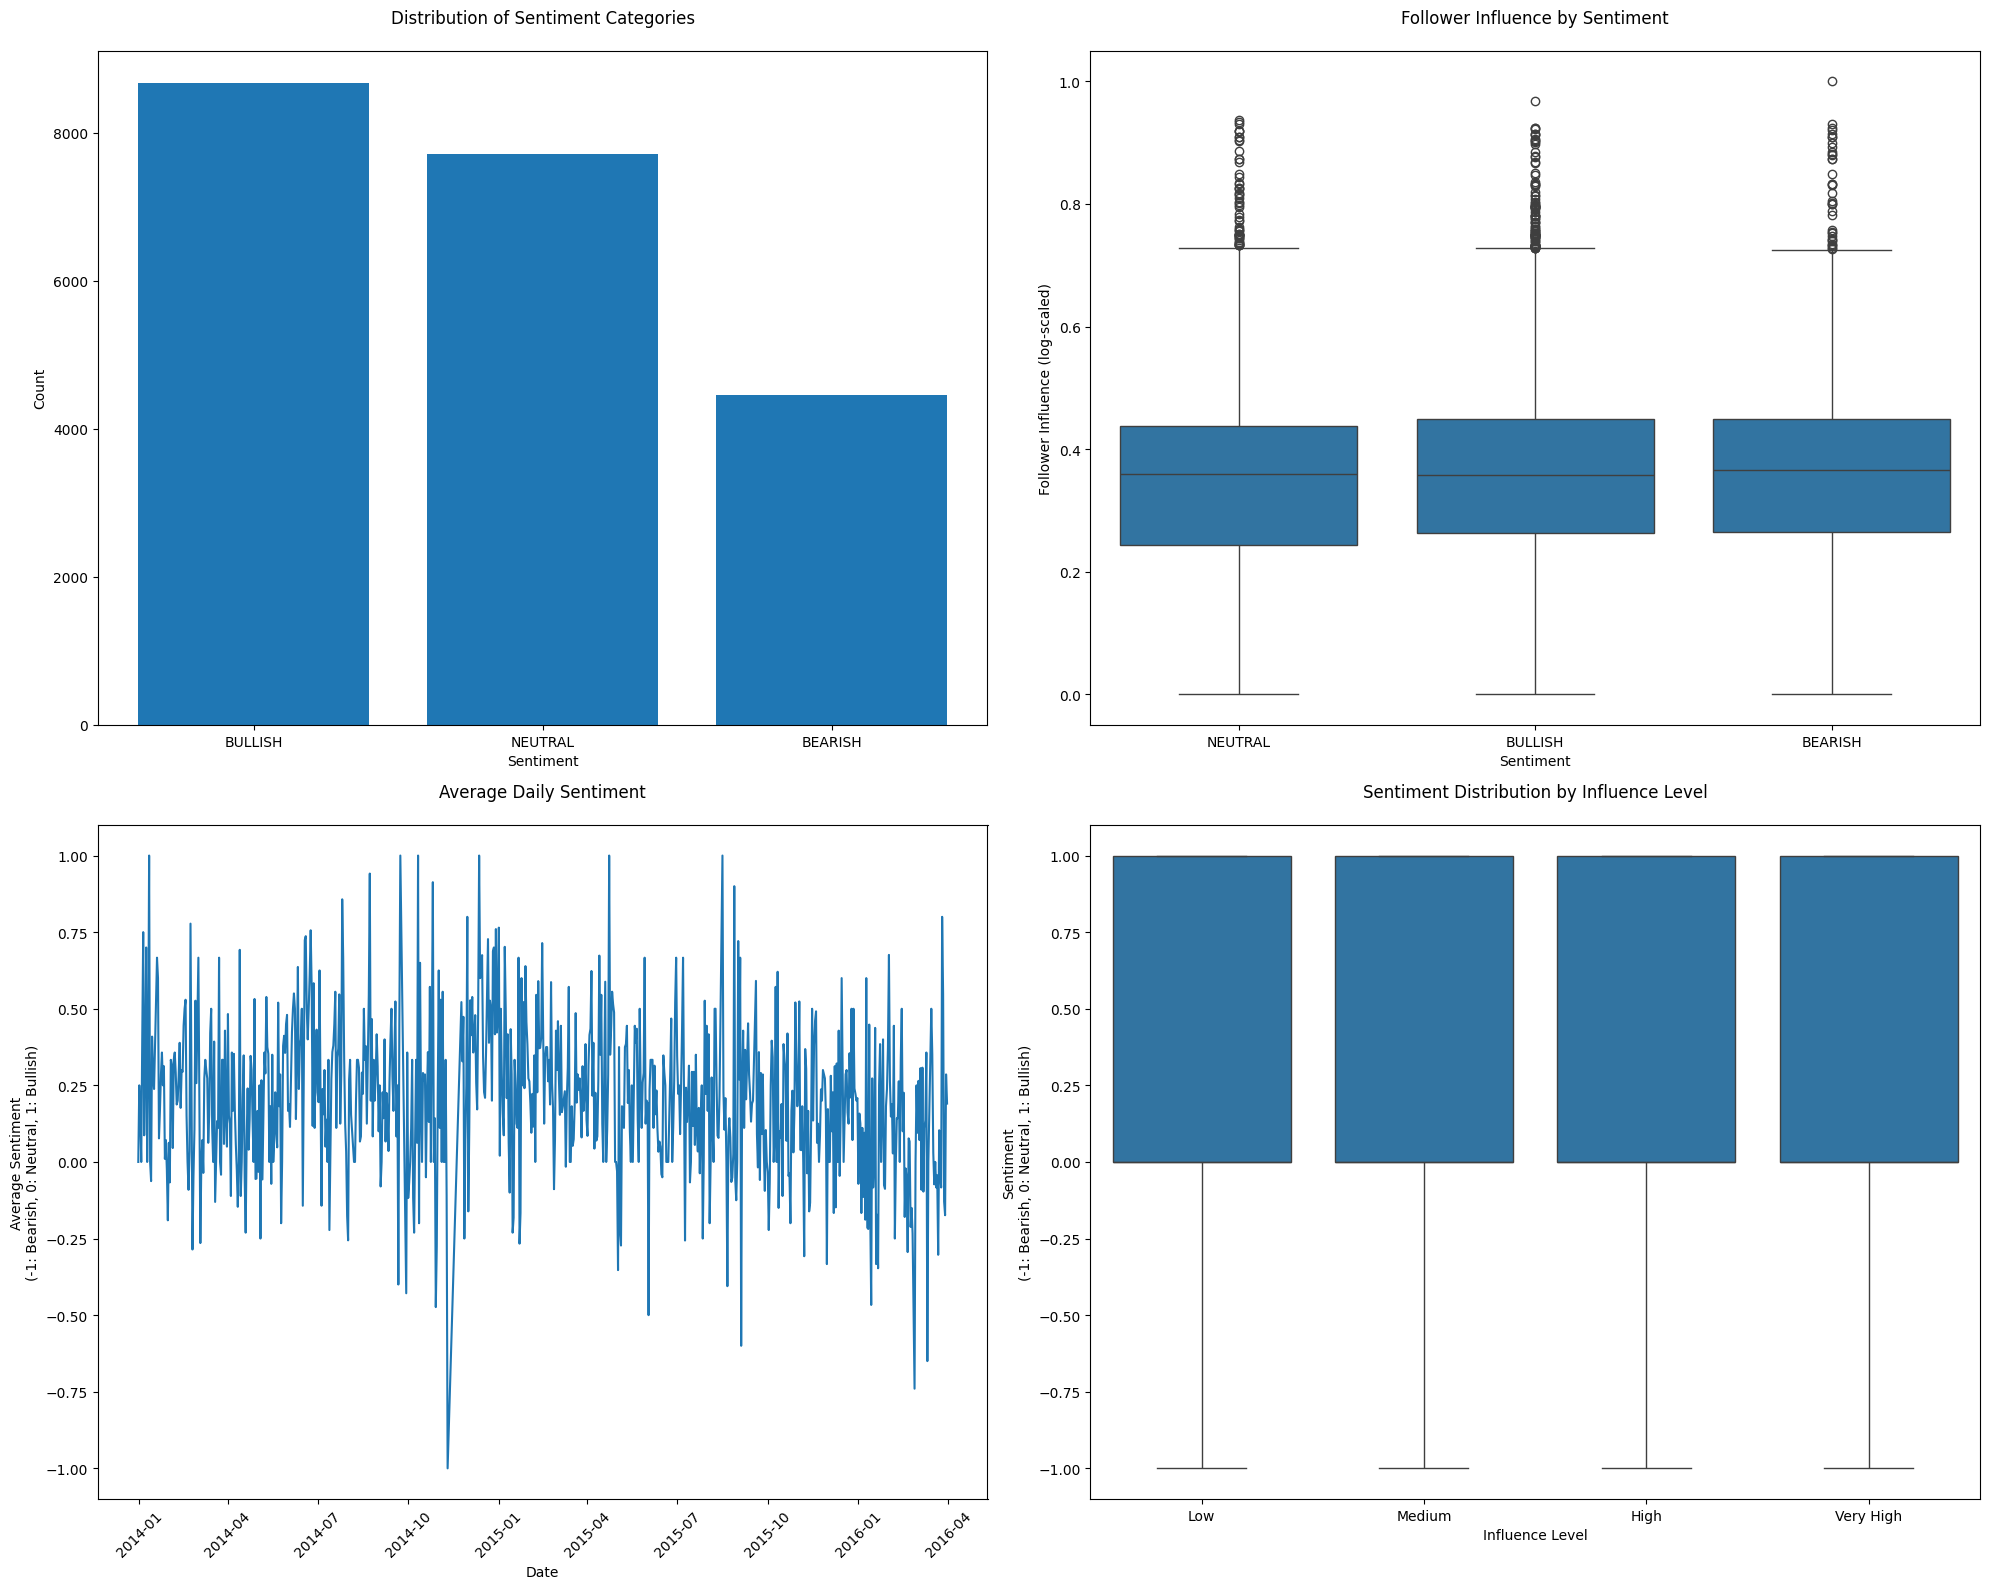

Number of influential tweets: 78


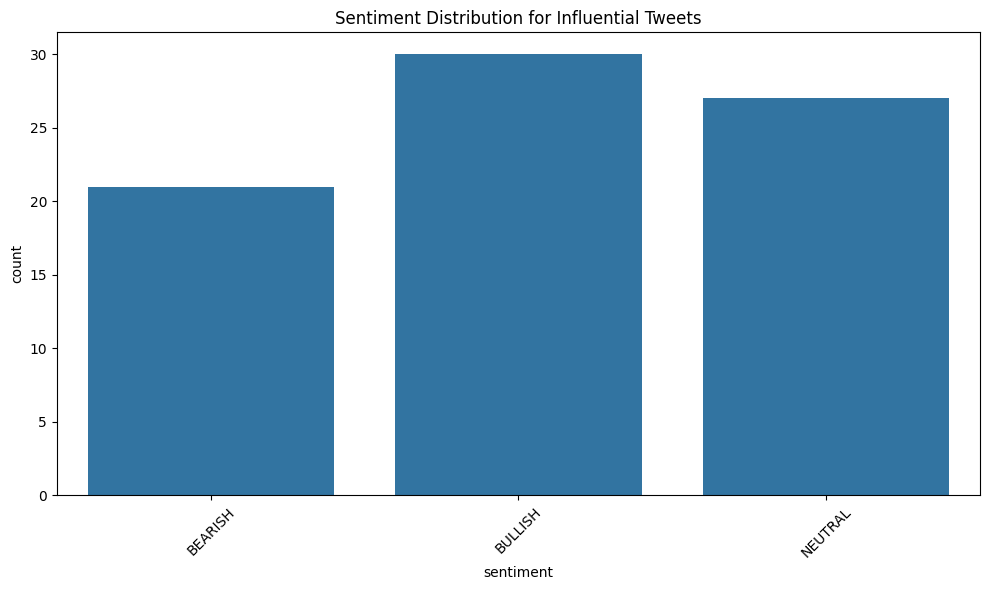

Top Influential Tweets:


,date,text_cleaned,sentiment,sentiment_numeric,follower_influence
11997,2014-10-20 20:03:27+00:00,iPad unit sales have fallen for 2 straight qua...,BEARISH,-1,1.000000
9182,2014-06-04 19:02:44+00:00,Apple is flirting with a 52-week high as its s...,BULLISH,1,0.967678
16281,2015-04-09 00:23:15+00:00,RT @WSJ: The Apple Watch isn't just a tiny iPh...,NEUTRAL,0,0.937390
14737,2015-03-09 17:16:46+00:00,RT @CNBCSocial: Meet Apple's latest store in C...,NEUTRAL,0,0.933162
10576,2015-02-23 13:20:00+00:00,"Despite competition in the smartphone sector, ...",BEARISH,-1,0.931116


Data saved successfully!


In [12]:
risk_manager = DataRiskManager()

df = pd.read_csv('tweets-sentiment-AAPL.csv')

print("Original Data Shape:", df.shape)
display(df.head())

processed_df = risk_manager.process_data(df)

print("\nProcessed Data Shape:", processed_df.shape)
display(processed_df.head())

risk_manager.visualize_sentiment_analysis(processed_df)

influential_tweets = risk_manager.analyze_influential_tweets(processed_df, threshold=0.8)

print("Top Influential Tweets:")
display(influential_tweets.head())

processed_df.to_csv('processed_apple_tweets.csv', index=False)
print("Data saved successfully!")